Category 7 - jet aircraft vibration exposure
====
Last update: 31 July 2018  

The following calculations are made to determine the $W_0$ vibration level for Figure 514.6D-1 of MIL-STD-810G, METHOD 514.6 ANNEX D.  Compare the Grms level to GAC guidance, DO-160 levels and other typical aircraft enviroments.  MIL-STD-810G provides guidance vibration levels for jet aircraft which can be used in the absence of measured data.  
  
MIL-STD-810G, METHOD 514.6 ANNEX D  
Operational Tailoring Guidance for Vibration Exposure Definition  
  
Exposure levels. Vibration criteria in the form of qualification test levels (see Annex A, paragraph 2.1.2) have been established for most airplanes developed for the military. Obtain these criteria through the program office responsible for the particular aircraft. This is the recommended basis for developing exposure levels. In cases where satisfactory criteria are not available, measured data may be available through the aircraft program office. Otherwise, measurements of actual vibrations are recommended.  
  
As a last resort, the guidance of Figure 514.6D-1 and Table 514.6D-I may be used to develop levels. Define both jet noise induced and aerodynamic noise induced levels for each flight condition of interest. The level for that flight condition is the envelope of the two.  
  
Table 514.6D-I – Category 7 - Jet aircraft vibration exposure. (pdf page 323)  
  
Exposure levels in acceleration spectral density (g2/Hz):  
  
$W_0 = W_A + \sum_{1}^n W_J$  
  
Aerodynamically induced vibration:  
  
$W_A = a × b × c × q^2$  
  
Jet engine noise induced vibration:  
  
$W_J = \lbrace[0.48 × a × d × cos^2(θ)/R] × [D_c × (V_c / V_r )^3 + D_f × (V_f / V_r )^3]\rbrace$  

In [1]:
import numpy as np
import collections # High-performance container datatypes
import matplotlib.pyplot as plt

In [2]:
# The NASA method of calculating Grms from the PSD
def calc_grms(psd):
    # step 1, calculate the octaves between each frequency
    freq = list(psd.keys())
    g2Hz = list(psd.values())
    num_oct = np.zeros(len(freq))
    for i in range(len(freq)-1):
        num_oct[i+1] = np.log10(freq[i+1]/freq[i])/np.log10(2)

    # step 2: calculate the dB values of the ratio between break points
    dB = np.zeros(len(g2Hz))
    for i in range(len(g2Hz)-1):
        dB[i+1] = 10*np.log10(g2Hz[i+1]/g2Hz[i])

    # step 3: calculate the slope of the segment between the frequencies FL and FH
    slope = np.zeros(len(freq))
    slope[1:] = dB[1:]/num_oct[1:]

    # step 4: calculate the area under the curve between the frequencies FL and FH
    area =  np.zeros(len(freq))
    for i in range(len(g2Hz)-1):
        if slope[i+1] != -10*np.log10(2):
            area[i+1] = 10*np.log10(2)*(g2Hz[i+1]/(10*np.log10(2)+slope[i+1]))*(freq[i+1]-freq[i]*
                    (freq[i]/freq[i+1])**(slope[i+1]/(10*np.log10(2))))
        else:
            area[i+1] = g2Hz[i]*freq[i]*np.log(freq[i+1]-freq[i])

    return np.sqrt(area.sum())

In [3]:
# Flight dynamic pressure, Table 514.6D-V, pdf page 335
# for h ≤ 11000 m (36,089 ft)
M = 0.5  # Mach number
Va = 340.28  # Local speed of sound, m/sec
theta = 1.0-2.2556e-5 # Ratio of temperature at altitude to sea level temperature
sigma = theta**4.2561 # Ratio of local atmospheric density to sea level atmospheric density
rho = 1.2251e-3 # Sea level atmospheric density
q = rho*sigma*Va**2*M**2 # Flight dynamic pressure
print('Flight dynamic pressure = {:.3f}'.format(q))

Flight dynamic pressure = 35.460


In [4]:
# Aerodynamically induced vibration, pdf page 323

# Platform/ Materiel interaction factor
W =  50 # for materiel weighing between 36.3 and 72.6 kg.(w = weight in kg) 
a = 10**(0.6-W/60)
a = 1  # materiel weighing less than 36.3 kg

# Proportionality factor between vibration level and dynamic pressure (SI units).
b = 2.96e-6  # for materiel mounted on cockpit instrument panels. using this because it's the lowest

# Mach number correction. 
c = 1.0 # equals 1 for 0 ≤ Mach ≤ 0. 9

W_a = a*b*c*q**2
print('Aerodynamically induced vibration = {:.3f}'.format(W_a))

Aerodynamically induced vibration = 0.004


## G-550 Specs  
The Gulfstream G550 is a business jet aircraft produced by General Dynamics' Gulfstream Aerospace unit in Savannah, Georgia, US.  
  
Powerplant: Rolls-Royce BR710 C4-11 high-ratio bypass turbofan, 15,385 lbf (68.44 kN)  
  
The BR710 comprises a 48 in (120 cm) diameter single-stage fan, driven by a two-stage LP turbine, supercharging a ten-stage HP compressor (scaled from the V2500 unit) and driven by a two-stage, air-cooled, HP turbine.  

NP-37B: U.S. military designation for proposed G550 with the "Conformal AEW" body shape for use as range telemetry aircraft for U.S. Navy.

PERFORMANCE
Maximum Range 12,501 km, Mach 0.80, 8 passengers, 4 crew and NBAA IFR reserves  
High-Speed: Mach 0.85  
Long-Range: Mach 0.80  
Initial Cruise Altitude: 12,497 m  
Maximum Cruise Altitude: 15,545 m  

In [5]:
# Jet engine noise induced vibration, pdf page 323
# Afterburner factor
d = 1 # = 1 for conditions where afterburner is not used or is not present

# Vector distance from center of engine exhaust plane to materiel center of gravity, m
R = 5

# Angle between R vector and engine exhaust vector (aft along engine exhaust centerline), degrees
theta = 70*np.pi/180  # For 70°< θ ≤ 180° use 70°

# Engine core exhaust diameter, m
Dc = 1.2/3  # 120cm dia fan reduced by 3 to get exhaust dia  ??? a guess

# Engine fan exhaust diameter, m
Df = 1.2/3

# Reference exhaust velocity, m/sec  <<<<----- need correct number
Vr = 564 # m/sec

# Engine core exhaust velocity Engine
Vc = 500 # core exhaust velocity (without afterburner)

# Engine fan exhaust velocity
Vf = 500 # m/sec

W_j = ((0.48*a*d*np.cos(theta)**2/R)*(Dc*(Vc/Vr)**3 + Df*(Vf/Vr)**3))
print('Jet engine noise induced vibration = {:.3f}'.format(W_j))

Jet engine noise induced vibration = 0.006


In [6]:
# Exposure levels
W_0 = W_a + 2*W_j
print('Exposure level = {:.3f}'.format(W_0))

Exposure level = 0.016


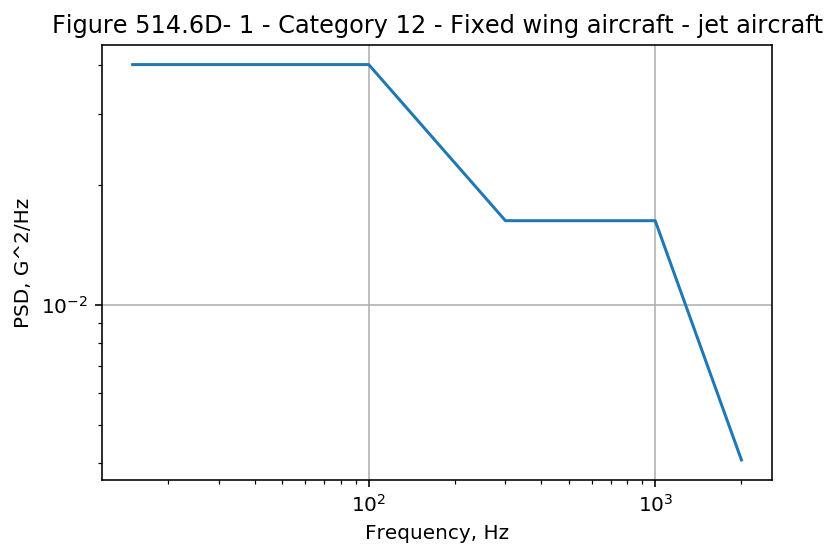

In [7]:
# need to find the -6dB/octave 2000Hz intercept point, from W_0, 1000Hz to 2000Hz, what is the level at 2000Hz?
freq2 = 2000
freq1 = 1000
num_oct = np.log10(freq2/freq1)/np.log10(2)
p1 = 10**((10*np.log10(W_0)-6*num_oct)/10)

# plot vibration profile
psd_cat7 = dict([(15, 0.04), (100, 0.04), (300, W_0), (1000, W_0), (2000, p1)])
#make sure the dictionary is ordered
psd_cat7 = collections.OrderedDict(sorted(psd_cat7.items()))

plt.grid(True)
plt.title('Figure 514.6D- 1 - Category 12 - Fixed wing aircraft - jet aircraft')
plt.xlabel('Frequency, Hz')
plt.ylabel('PSD, G^2/Hz')
plt.loglog(list(psd_cat7.keys()), list(psd_cat7.values()))

In [8]:
# calculate overall grms level
print('Grms value: {:.3f}'.format(calc_grms(psd_cat7)))

Grms value: 5.269


# DO-160 curves
RTCA/D0-160D  
Environmental Conditions and Test Procedures for Airborne Equipment  
Section 8, Vibration  
  
Note that the zone for "instrument panel, console and racks" includes interior items attached to the galley interior partitions and cabin floor and is separate from the "fuselage" zone. The "fuselage" zone applies to all equipment not installed in multiple slot equipment racks but that is attached to frames, stringers, skin and other fuselage structure or brackets.

pdf page 79  

Table 8-1 Categorization and Vibration Tests by Aircraft Types and Equipment Locations  
AIRCRAFT TYPE: Fixed Wing, Turbojet or Turbofan Engines (Subsonic Supersonic)  
AIRCRAFT ZONE: 2 - INSTRUMENT PANEL, CONSOLE & EQUIPMENT RACK  
TEST CATEGORY: S or S2  
VIBRATION TEST CURVES (1) (2)  
(B)=1.48grms or (B2)=0.7grms (4)  
(4) Curves B2 and B12 are the same as those found in RTCA/DO-160C as B and B , respectively. They are representative of levels expected on many fixed wing aircraft but may not be sufficient for all. Curves B and B1 contain higher levels and reflect the expected environment for all cases.  
  
AIRCRAFT ZONE: 1 FUSELAGE   
VIBRATION TEST CURVES  
(C)=4.12grms (3)  
(3) Does not include equipment mounted on structure directly affected by jet efflux.  

Text(0,0.5,'PSD, G^2/Hz')

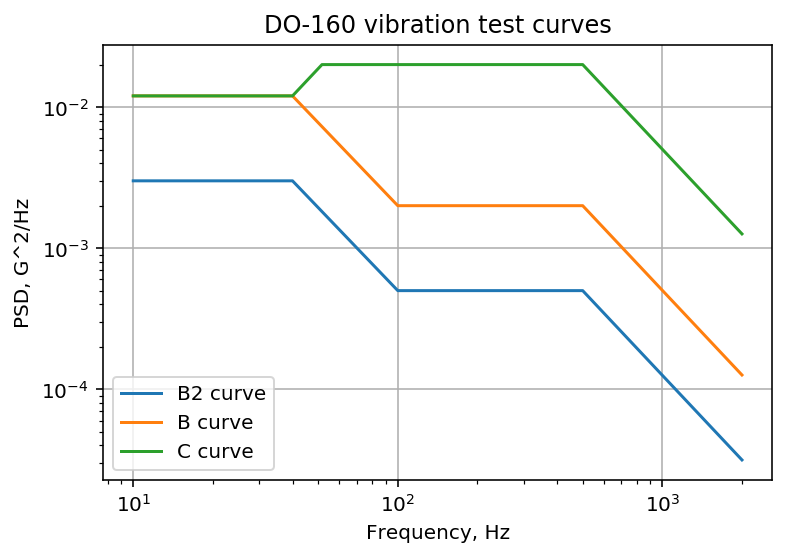

In [9]:
# psd_B2: AIRCRAFT ZONE: 2 - INSTRUMENT PANEL, CONSOLE & EQUIPMENT RACK, TEST CATEGORY: S or S2 
# calculate the curve end point at 2000Hz
p1_B2 = 0.0005 # level from 100 to 500 Hz
freq1 = 500
freq2 = 2000
num_oct = np.log10(freq2/freq1)/np.log10(2)
p2_B2 = 10**((10*np.log10(p1_B2)-6*num_oct)/10)

psd_B2 = dict([(10, 0.003), (40, 0.003), (100, p1_B2), (500, p1_B2), (2000, p2_B2)])
#make sure the dictionary is ordered
psd_B2 = collections.OrderedDict(sorted(psd_B2.items()))
plt.loglog(list(psd_B2.keys()), list(psd_B2.values()),label='B2 curve')

# psd_B: AIRCRAFT ZONE: 2 - INSTRUMENT PANEL, CONSOLE & EQUIPMENT RACK, TEST CATEGORY: S or S2 
# calculate the curve end point at 2000Hz
p1_B = 0.002 # level from 100 to 500 Hz
freq1 = 500
freq2 = 2000
num_oct = np.log10(freq2/freq1)/np.log10(2)
p2_B = 10**((10*np.log10(p1_B)-6*num_oct)/10)

psd_B = dict([(10, 0.012), (40, 0.012), (100,p1_B), (500, p1_B), (2000, p2_B)])
# make sure the dictionary is ordered
psd_B = collections.OrderedDict(sorted(psd_B.items()))
plt.loglog(list(psd_B.keys()), list(psd_B.values()),label='B curve')

# psd_C: AIRCRAFT ZONE: 2 - INSTRUMENT PANEL, CONSOLE & EQUIPMENT RACK, TEST CATEGORY: S or S2 
# calculate the curve end point at 2000Hz
p1_C = 0.02 # level from 100 to 500 Hz
freq1 = 500
freq2 = 2000
num_oct = np.log10(freq2/freq1)/np.log10(2)
p2_C = 10**((10*np.log10(p1_C)-6*num_oct)/10)

psd_C = dict([(10, 0.012), (40, 0.012), (51.7,p1_C), (500, p1_C), (2000, p2_C)])
# make sure the dictionary is ordered
psd_C = collections.OrderedDict(sorted(psd_C.items()))

plt.loglog(list(psd_C.keys()), list(psd_C.values()),label='C curve')

plt.grid(True)
plt.legend()
plt.title('DO-160 vibration test curves')
plt.xlabel('Frequency, Hz')
plt.ylabel('PSD, G^2/Hz')

In [10]:
# calculate overall grms level
print('curve B2: {:.3f} Grms'.format(calc_grms(psd_B2)))
print('curve B: {:.3f} Grms'.format(calc_grms(psd_B)))
print('curve C: {:.3f} Grms'.format(calc_grms(psd_C)))

curve B2: 0.743 Grms
curve B: 1.485 Grms
curve C: 4.128 Grms


## commercial examples
MP70S ARINC 600 Network Server: Vibration (standard): RTCA DO-160G Section 8, Cat. S, Curve B §8.5.2  
Rosen Media Port: Random Vibration – Fixed Wing Aircraft 8.5.2 S (Curve B)  
RosenView MX: Random Vibration – Fixed Wing Aircraft 8.5.2 S (Curve B) DO-160F  
ICOM IC-A220 VHF Air Band Transceiver Equipment tested to Category S, Test Curves B & M  



http://mil-embedded.com/articles/certifying-cots-avionics-hardware-to-dal-a-is-common-sense/
